In [64]:
import pandas as pd
import yaml
import spotipy
import spotipy.util as util

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

## Configurando a comunicação

In [13]:
def load_config():
    stream = open('config.yaml')
    user_config = yaml.load(stream, Loader=yaml.FullLoader)
    return user_config

user_config = load_config()

In [71]:
#token = util.prompt_for_user_token(user_config['username'], scope='playlist-read-private', client_id=user_config['client_id'], client_secret=user_config['client_secret'], redirect_uri=user_config['redirect_uri'])

token = util.prompt_for_user_token(user_config['username'], scope='playlist-modify-public', client_id=user_config['client_id'], client_secret=user_config['client_secret'], redirect_uri=user_config['redirect_uri'])
sp = spotipy.Spotify(auth=token)

## Funções auxiliares

In [15]:
def get_playlist_info(username, playlist_uri):
    offset = 0
    tracks, uris, names, artists = [], [], [], []

    playlist_id = playlist_uri.split(':')[2]
    playlist_name = sp.user_playlist(username, playlist_id)['name']

    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
        else:
            break
        
    for track in tracks:
        names.append(track['track']['name'])
        artists.append(track['track']['artists'][0]['name'])
        uris.append(track['track']['uri'])
    
    return playlist_name, names, artists, uris

In [21]:
playlist_uri = 'spotify:playlist:37i9dQZF1DWUMIaJLw9MPy'
get_playlist_info(user_config['username'], playlist_uri)

('Cantando com Mundo Bita',
 ['Odara',
  'É Alegria',
  'O Leãozinho',
  'O Amor É Tudo de Bom',
  'Pra Lidar Com a Raiva',
  'Que É Que o Macaco É?',
  'Amiga Baleia',
  'Vento Ventania',
  'Fazendinha',
  'Dona Girafa',
  'Fazendinha Sambão - Remix',
  'O Morcego (Me Perdoe a Hora)',
  'Lá no Galinheiro',
  'La Bamba',
  'Todo Mundo Chora',
  'Que Saudade Que Eu Tô',
  'Bagunça de Criança',
  'Aquilo Que Te Move',
  'O Esporte Que Escolher',
  'Meu Papai',
  'O Amor da Adoção',
  'Querida Chupeta, Bye-Bye',
  'Hora de Tomar Vacina',
  'Nessa Dança',
  'O Carimbador Maluco',
  'Mãe Música',
  'Como É Grande o Meu Amor por Você',
  'Fundo do Mar',
  'Viajar Pelo Safari',
  'Matemagicamente',
  'Como uma Onda',
  'O Circo Chegou',
  'Palhaçada',
  'A Vida do Viajante',
  'Dinossauros',
  'De Estimação',
  'Como é Verde na Floresta',
  'Para Papar',
  'Ai, Que Vontade!',
  'Hora da Escola',
  'Chuá Tchibum',
  'O Parquinho',
  'O Sol Já Vem',
  'São João do Bita',
  'Xic, Xic, Xic',
  'P

In [16]:
def get_features_for_playlist(df, username, uri):
  
    playlist_name, names, artists, uris = get_playlist_info(username, uri)
    
    for name, artist, track_uri in zip(names, artists, uris):

        audio_features = sp.audio_features(track_uri)

        feature_subset = [audio_features[0][col] for col in df.columns if col not in ["name", "artist", "track_URI", "playlist"]]

        row = [name, artist, track_uri, *feature_subset, playlist_name]
        df.loc[len(df.index)] = row
    return df

In [22]:
track_uri = 'spotify:track:6WoKiuHQSzZtfjaHwYDbuk'
sp.audio_features(track_uri)

[{'danceability': 0.593,
  'energy': 0.735,
  'key': 11,
  'loudness': -7.919,
  'mode': 1,
  'speechiness': 0.0353,
  'acousticness': 0.0181,
  'instrumentalness': 0.000435,
  'liveness': 0.134,
  'valence': 0.844,
  'tempo': 174.991,
  'type': 'audio_features',
  'id': '6WoKiuHQSzZtfjaHwYDbuk',
  'uri': 'spotify:track:6WoKiuHQSzZtfjaHwYDbuk',
  'track_href': 'https://api.spotify.com/v1/tracks/6WoKiuHQSzZtfjaHwYDbuk',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6WoKiuHQSzZtfjaHwYDbuk',
  'duration_ms': 165086,
  'time_signature': 4}]

In [74]:
#playlist_uri = 'spotify:playlist:37i9dQZF1DX9FSYmdU9mbT'
playlist_uri = 'spotify:playlist:7K8SQif6BmZv6KWndNj9QW'

df = pd.DataFrame(columns=['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist'])
df

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist


In [75]:
df = get_features_for_playlist(df, user_config['username'], playlist_uri)
df

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
0,Ex's & Oh's,Elle King,spotify:track:70eDxAyAraNTiD6lx2ZEnH,0.01830,0.612,0.921,0.000000,0.0576,-2.882,0.0850,139.988,0.446,Nova playlist 2
1,Yesterday - Remastered 2015,The Beatles,spotify:track:63uskN0xLezVg4281wzeQn,0.87100,0.401,0.189,0.000000,0.0968,-11.189,0.0287,94.509,0.357,Nova playlist 2
2,Cocaine,Eric Clapton,spotify:track:2udGjDmpK1dH9VGyw7nrei,0.06070,0.699,0.502,0.033700,0.3170,-12.526,0.0278,105.267,0.676,Nova playlist 2
3,Hotel California - 2013 Remaster,Eagles,spotify:track:40riOy7x9W7GXjyGp4pjAv,0.00574,0.579,0.508,0.000494,0.0575,-9.484,0.0270,147.125,0.609,Nova playlist 2
4,Strawberry Fields Forever - Remastered,The Beatles,spotify:track:5EuraV2jbqB15ihd3d2Hex,0.33600,0.390,0.502,0.000138,0.0713,-12.277,0.1780,97.871,0.289,Nova playlist 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,Hey Ya!,Outkast,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,0.10300,0.727,0.974,0.000532,0.1740,-2.261,0.0664,79.526,0.965,Nova playlist 2
882,Wish You Were Here - 2011 Remaster,Pink Floyd,spotify:track:7aE5WXu5sFeNRh3Z05wwu4,0.72800,0.500,0.185,0.000746,0.2730,-20.242,0.0535,121.002,0.293,Nova playlist 2
883,bad guy,Billie Eilish,spotify:track:2Fxmhks0bxGSBdJ92vM42m,0.32800,0.701,0.425,0.130000,0.1000,-10.965,0.3750,135.128,0.562,Nova playlist 2
884,La Vie En Rose,Lady Gaga,spotify:track:3tv3f29zjhzL3kcvQE8tGl,0.75800,0.276,0.405,0.000000,0.7060,-7.296,0.0329,76.180,0.335,Nova playlist 2


## Testando as Features

In [28]:
df[df['energy']==df['energy'].max()]

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
61,Anunciação - Ao Vivo,Alceu Valença,spotify:track:3JrFuUhcNLHiD3hJPVaHTy,0.419,0.54,0.898,0.000001,0.984,-7.18,0.0528,109.984,0.473,O Melhor da MPB


In [29]:
df[df['energy']==df['energy'].min()]

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
28,Outra Vez,Roberto Carlos,spotify:track:33dHjdJ014lYbaQ0DXfzKw,0.806,0.391,0.0572,0.0,0.114,-23.63,0.0413,135.771,0.173,O Melhor da MPB


In [30]:
df[df['danceability']==df['danceability'].max()]

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
86,Lança Perfume,Rita Lee,spotify:track:0rAX31FT5w3ZQbQMUSkxy8,0.0396,0.843,0.528,0.0202,0.0594,-12.88,0.0473,127.284,0.962,O Melhor da MPB


## Análise de componentes principais (PCA)

In [76]:
df_X = df.drop(columns=['name', 'artist', 'track_URI', 'playlist'])
df_X

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.01830,0.612,0.921,0.000000,0.0576,-2.882,0.0850,139.988,0.446
1,0.87100,0.401,0.189,0.000000,0.0968,-11.189,0.0287,94.509,0.357
2,0.06070,0.699,0.502,0.033700,0.3170,-12.526,0.0278,105.267,0.676
3,0.00574,0.579,0.508,0.000494,0.0575,-9.484,0.0270,147.125,0.609
4,0.33600,0.390,0.502,0.000138,0.0713,-12.277,0.1780,97.871,0.289
...,...,...,...,...,...,...,...,...,...
881,0.10300,0.727,0.974,0.000532,0.1740,-2.261,0.0664,79.526,0.965
882,0.72800,0.500,0.185,0.000746,0.2730,-20.242,0.0535,121.002,0.293
883,0.32800,0.701,0.425,0.130000,0.1000,-10.965,0.3750,135.128,0.562
884,0.75800,0.276,0.405,0.000000,0.7060,-7.296,0.0329,76.180,0.335


Padronização dos dados

In [77]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_X)

In [39]:
pca = PCA()
pca.fit(X_std)

PCA()

In [78]:
evr = pca.explained_variance_ratio_
evr

array([0.28173366, 0.1560153 , 0.14153967, 0.11938157, 0.08692216,
       0.07197593])

In [ ]:
fig = plt.figure()
plt.plot(range(1, len(df_X.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)

In [80]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)

Number of components: 6


In [81]:
pca = PCA(n_components=n_comps)
pca.fit(X_std)
scores_pca = pca.transform(X_std)

## Usando o K-Means

In [82]:
#pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

Busca da melhor quantidade de grupos

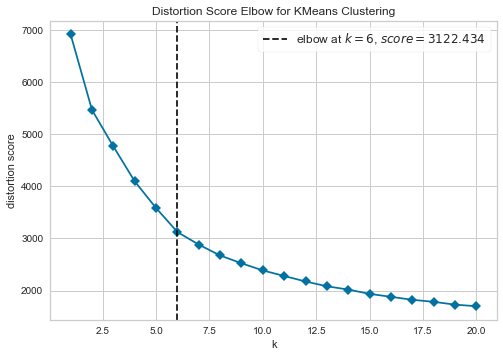

Optimal number of clusters: 6


In [83]:
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=(1,21), timings=False)
visualizer.fit(scores_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

In [84]:
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=6, random_state=42)

In [85]:
kmeans_pca.labels_

array([2, 1, 0, 2, 1, 1, 0, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 5, 5,
       1, 0, 2, 1, 2, 2, 1, 4, 1, 1, 0, 1, 0, 0, 2, 2, 1, 2, 1, 2, 1, 2,
       1, 0, 0, 0, 3, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 2, 0, 0,
       4, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 5, 4, 0, 4, 2, 2, 2, 2, 2, 1, 0,
       0, 0, 0, 5, 5, 2, 1, 0, 2, 0, 2, 2, 5, 0, 0, 2, 4, 0, 0, 0, 0, 0,
       0, 0, 1, 3, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2, 0, 1, 2, 2, 0, 2, 0, 0,
       0, 0, 2, 5, 5, 5, 2, 2, 0, 1, 0, 2, 2, 1, 0, 0, 3, 4, 2, 0, 2, 2,
       2, 2, 0, 2, 1, 2, 2, 0, 2, 5, 3, 2, 0, 0, 0, 3, 1, 0, 3, 2, 2, 2,
       2, 3, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 0, 1, 1, 5, 0, 3, 3, 3,
       1, 2, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 0,
       0, 2, 2, 0, 1, 1, 2, 2, 0, 2, 0, 1, 0, 0, 5, 0, 0, 1, 0, 0, 5, 2,
       0, 0, 0, 1, 1, 0, 3, 1, 1, 1, 3, 0, 2, 3, 1, 2, 1, 0, 2, 2, 2, 3,
       2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 1, 2, 4, 2, 0, 3, 0, 1,
       0, 0, 1, 0, 5, 5, 0, 3, 5, 0, 2, 1, 0, 3, 4,

Juntando as features e componentes principais no mesmo DataFrame

In [86]:
df_seg_pca_kmeans = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca_kmeans.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
df_seg_pca_kmeans['Cluster'] = kmeans_pca.labels_

In [87]:
df_seg_pca_kmeans

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Cluster
0,0.01830,0.612,0.921,0.000000,0.0576,-2.882,0.0850,139.988,0.446,-1.787543,-0.568162,-0.845384,-0.371210,-0.411376,0.500737,2
1,0.87100,0.401,0.189,0.000000,0.0968,-11.189,0.0287,94.509,0.357,3.490200,-0.540932,0.247246,-0.802078,-0.341030,-0.477283,1
2,0.06070,0.699,0.502,0.033700,0.3170,-12.526,0.0278,105.267,0.676,0.882622,0.704489,-0.239999,0.184478,0.608706,-0.905098,0
3,0.00574,0.579,0.508,0.000494,0.0575,-9.484,0.0270,147.125,0.609,0.254686,-0.227702,-1.085719,0.250667,-0.958467,-0.417157,2
4,0.33600,0.390,0.502,0.000138,0.0713,-12.277,0.1780,97.871,0.289,1.855047,-0.482352,0.123950,-0.711112,-0.305148,1.223589,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,0.10300,0.727,0.974,0.000532,0.1740,-2.261,0.0664,79.526,0.965,-2.273661,1.265569,-0.818876,-0.776380,1.401835,-0.912122,0
882,0.72800,0.500,0.185,0.000746,0.2730,-20.242,0.0535,121.002,0.293,4.510793,-0.180786,0.844726,0.354861,-0.841534,-0.547741,1
883,0.32800,0.701,0.425,0.130000,0.1000,-10.965,0.3750,135.128,0.562,1.161528,1.852278,0.224013,1.402591,-0.603626,2.000801,3
884,0.75800,0.276,0.405,0.000000,0.7060,-7.296,0.0329,76.180,0.335,1.899366,-1.687241,2.680303,-0.664303,1.590713,-0.900693,5


c:\Users\307145\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Component 1', ylabel='Component 2'>

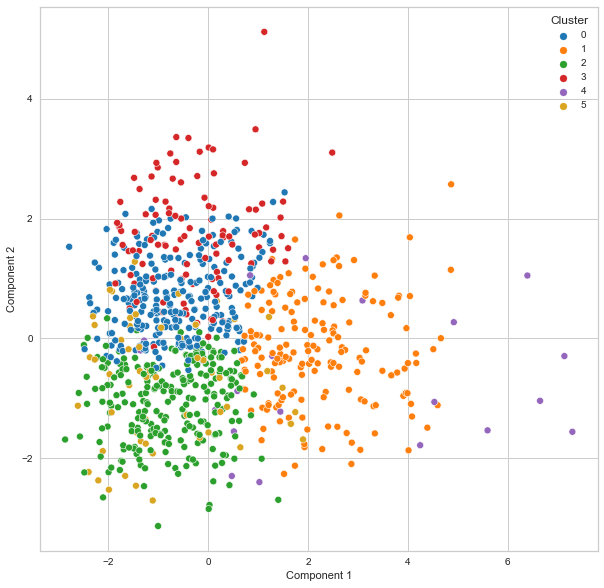

In [89]:
x = df_seg_pca_kmeans['Component 1']
y = df_seg_pca_kmeans['Component 2']

plt.figure(figsize=(10,10))

#palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'goldenrod', 'tab:cyan']
palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'goldenrod']

sns.scatterplot(x,y, hue=df_seg_pca_kmeans['Cluster'], palette=palette)

In [90]:
df['Cluster'] = kmeans_pca.labels_
df

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
0,Ex's & Oh's,Elle King,spotify:track:70eDxAyAraNTiD6lx2ZEnH,0.01830,0.612,0.921,0.000000,0.0576,-2.882,0.0850,139.988,0.446,Nova playlist 2,2
1,Yesterday - Remastered 2015,The Beatles,spotify:track:63uskN0xLezVg4281wzeQn,0.87100,0.401,0.189,0.000000,0.0968,-11.189,0.0287,94.509,0.357,Nova playlist 2,1
2,Cocaine,Eric Clapton,spotify:track:2udGjDmpK1dH9VGyw7nrei,0.06070,0.699,0.502,0.033700,0.3170,-12.526,0.0278,105.267,0.676,Nova playlist 2,0
3,Hotel California - 2013 Remaster,Eagles,spotify:track:40riOy7x9W7GXjyGp4pjAv,0.00574,0.579,0.508,0.000494,0.0575,-9.484,0.0270,147.125,0.609,Nova playlist 2,2
4,Strawberry Fields Forever - Remastered,The Beatles,spotify:track:5EuraV2jbqB15ihd3d2Hex,0.33600,0.390,0.502,0.000138,0.0713,-12.277,0.1780,97.871,0.289,Nova playlist 2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,Hey Ya!,Outkast,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,0.10300,0.727,0.974,0.000532,0.1740,-2.261,0.0664,79.526,0.965,Nova playlist 2,0
882,Wish You Were Here - 2011 Remaster,Pink Floyd,spotify:track:7aE5WXu5sFeNRh3Z05wwu4,0.72800,0.500,0.185,0.000746,0.2730,-20.242,0.0535,121.002,0.293,Nova playlist 2,1
883,bad guy,Billie Eilish,spotify:track:2Fxmhks0bxGSBdJ92vM42m,0.32800,0.701,0.425,0.130000,0.1000,-10.965,0.3750,135.128,0.562,Nova playlist 2,3
884,La Vie En Rose,Lady Gaga,spotify:track:3tv3f29zjhzL3kcvQE8tGl,0.75800,0.276,0.405,0.000000,0.7060,-7.296,0.0329,76.180,0.335,Nova playlist 2,5


In [91]:
df[df['Cluster']==1]

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
1,Yesterday - Remastered 2015,The Beatles,spotify:track:63uskN0xLezVg4281wzeQn,0.871,0.401,0.189,0.000000,0.0968,-11.189,0.0287,94.509,0.357,Nova playlist 2,1
4,Strawberry Fields Forever - Remastered,The Beatles,spotify:track:5EuraV2jbqB15ihd3d2Hex,0.336,0.390,0.502,0.000138,0.0713,-12.277,0.1780,97.871,0.289,Nova playlist 2,1
5,Like a Rolling Stone,Bob Dylan,spotify:track:3AhXZa8sUQht0UEdBJgpGc,0.731,0.482,0.721,0.000000,0.1890,-6.839,0.0321,95.263,0.557,Nova playlist 2,1
9,Dream On,Aerosmith,spotify:track:5MxNLUsfh7uzROypsoO5qe,0.388,0.307,0.433,0.000091,0.3320,-10.057,0.0290,160.900,0.224,Nova playlist 2,1
12,Do I Wanna Know?,Arctic Monkeys,spotify:track:2UzMpPKPhbcC8RbsmuURAZ,0.174,0.550,0.532,0.000347,0.2180,-7.591,0.0320,85.032,0.410,Nova playlist 2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,Convite para Nascer de Novo,Erasmo Carlos,spotify:track:0zvvjjj3MkBwhWWxrOfflu,0.256,0.703,0.361,0.000053,0.0962,-14.385,0.0371,138.171,0.368,Nova playlist 2,1
866,Poema,Ney Matogrosso,spotify:track:7qvL8BbYdxvhOinapMiEeF,0.728,0.606,0.563,0.000362,0.3350,-6.604,0.0307,124.181,0.464,Nova playlist 2,1
879,Tempo de Pipa,Cícero,spotify:track:40rIF99coDZOA10HnF46R4,0.840,0.639,0.468,0.015000,0.1010,-9.568,0.0254,109.013,0.610,Nova playlist 2,1
882,Wish You Were Here - 2011 Remaster,Pink Floyd,spotify:track:7aE5WXu5sFeNRh3Z05wwu4,0.728,0.500,0.185,0.000746,0.2730,-20.242,0.0535,121.002,0.293,Nova playlist 2,1


## Criando as playlists

In [93]:
for i in range(n_clusters):
    result = sp.user_playlist_create(user_config['username'], 'cluster'+str(i), public=True, collaborative=False, description='')
    playlist_id = result['id']
    songs = list(df.loc[df['Cluster'] == i]['track_URI'])
    if len(songs) > 100:
        sp.playlist_add_items(playlist_id, songs[:100])
        if len(songs) > 200:
            sp.playlist_add_items(playlist_id, songs[100:200])
        else:
            sp.playlist_add_items(playlist_id, songs[100:])
    else:
        sp.playlist_add_items(playlist_id, songs)


## Análise usando Radar Chart

In [102]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [99]:
def make_normalized_df(df, col_sep):
    non_features = df[df.columns[:col_sep]]
    features = df[df.columns[col_sep:]]
    norm = MinMaxScaler().fit_transform(features)
    scaled = pd.DataFrame(norm, index=df.index, columns = df.columns[col_sep:])
    return pd.concat([non_features, scaled], axis=1)

cluster_labels = df['Cluster']
orig = df.drop(columns=['playlist', 'Cluster'])
values_df = make_normalized_df(orig, 3)
values_df.insert(3, 'cluster', cluster_labels)
values_df

,name,artist,track_URI,cluster,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,Ex's & Oh's,Elle King,spotify:track:70eDxAyAraNTiD6lx2ZEnH,2,0.018439,0.553729,0.925761,0.000000,0.036179,0.877648,0.092708,0.554439,0.435570
1,Yesterday - Remastered 2015,The Beatles,spotify:track:63uskN0xLezVg4281wzeQn,1,0.878023,0.286979,0.149433,0.000000,0.076700,0.529813,0.007003,0.284754,0.340788
2,Cocaine,Eric Clapton,spotify:track:2udGjDmpK1dH9VGyw7nrei,0,0.061181,0.663717,0.481387,0.034886,0.304321,0.473830,0.005633,0.348547,0.680511
3,Hotel California - 2013 Remaster,Eagles,spotify:track:40riOy7x9W7GXjyGp4pjAv,2,0.005777,0.512010,0.487751,0.000511,0.036076,0.601206,0.004415,0.596761,0.609159
4,Strawberry Fields Forever - Remastered,The Beatles,spotify:track:5EuraV2jbqB15ihd3d2Hex,1,0.338704,0.273072,0.481387,0.000143,0.050341,0.484256,0.234282,0.304690,0.268371
...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,Hey Ya!,Outkast,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,0,0.103823,0.699115,0.981971,0.000551,0.156502,0.903651,0.064393,0.195906,0.988285
882,Wish You Were Here - 2011 Remaster,Pink Floyd,spotify:track:7aE5WXu5sFeNRh3Z05wwu4,1,0.733869,0.412137,0.145190,0.000772,0.258838,0.150741,0.044756,0.441854,0.272630
883,bad guy,Billie Eilish,spotify:track:2Fxmhks0bxGSBdJ92vM42m,3,0.330639,0.666245,0.399724,0.134576,0.080008,0.539193,0.534176,0.525620,0.559105
884,La Vie En Rose,Lady Gaga,spotify:track:3tv3f29zjhzL3kcvQE8tGl,5,0.764111,0.128951,0.378513,0.000000,0.706430,0.692823,0.013396,0.176065,0.317359


In [103]:
fig = go.Figure()

angles = list(values_df.columns[4:])
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Cluster " + str(i)))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True
        )
fig.show()